# BiLSTM et CRF

Dans ce notebook nous nous utilisons les champs aléatoires conditionnels (conditional random fields ou CRFs) qui sont généralement utilisés pour le named entityy recognition dans le but de prédire des séquences valides.
Par exemple, on ne devrait pas avoir de `B-PER` suivi directement par un autre `B-PER`.
Pour l'implémentation CRF, on utilisera le package [pytorch-crf](https://github.com/kmkurn/pytorch-crf).

In [1]:
#!pip install torchtext==0.6.0
#!pip install pytorch-crf

import time
import torch
from torch import nn
from torch.optim import Adam
from torchtext.data import Field, NestedField, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
from torchcrf import CRF
import numpy as np
import pandas as pd

import time
import random
import string
from itertools import chain

# Préparation des données

In [2]:
# pour la reproductibilité
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(lower = False) 
TAG = data.Field(unk_token = None) # les tags sont tous connus on a alors unk_token = None

my_path = "data_ner/"
train_data, valid_data, test_data = data.TabularDataset.splits(
        path= my_path ,
        train="train.csv",
        validation="valid.csv",
        test="test.csv", format='csv', skip_header=True,
        fields=(("text", TEXT), ("tag", TAG))
    )
MIN_FREQ = 0

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ, # les mots qui apparaissent moins que MIN_FREQ fois seront ignorés du vocabulaire
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)


TAG.build_vocab(train_data)
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device, sort=False)

# padding index
TEXT_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

# Construire le modèle

Pour la classe de modèle, il existe trois mises à jour principales:

1. préparez la couche CRF lors de l'initialisation. Nous devons spécifier le nombre de tags possibles dans le text.
2. inclure la logique de la couche CRF dans la séquence `forward ()`. Il y a un changement majeur dans le `forward ()` en raison de l'implémentation du package `pytorch-crf`. Jusqu'à présent, nous effectuons séparément la propagation forward et le calcul des pertes. Désormais, le calcul des pertes est intégré à la propagation forward.
3. initialisez toutes les transitions impossibles avec un nombre vraiment bas (-100) dans la fonction `init_crf_transitions`. C'est là que nous imposons la logique de séquence BIO au modèle.

In [3]:
class BiLSTM(nn.Module):

    def __init__(self,
                 input_dim,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 lstm_layers,
                 emb_dropout,
                 lstm_dropout,
                 fc_dropout,
                 word_pad_idx,
                 tag_pad_idx):
        super().__init__()
        
        # LAYER 1: Word Embedding
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=embedding_dim,
            padding_idx=word_pad_idx
        )
        self.emb_dropout = nn.Dropout(emb_dropout)
        

        # LAYER 2: BiLSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            bidirectional=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0
        )
        
        # LAYER 3: Fully-connected  
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  
        # LAYER 4: CRF

        self.tag_pad_idx = tag_pad_idx
        self.crf = CRF(num_tags=output_dim)
        
        # init poids avec distribution normale 
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, words, tags=None):

        # words = [sentence length, batch size]
        # chars = [batch size, sentence length, word length)
        # tags = [sentence length, batch size]
        
        # embedding_out = [sentence length, batch size, embedding dim]
        embedding_out = self.emb_dropout(self.embedding(words))

        # lstm_out = [sentence length, batch size, hidden dim * 2]
        lstm_out, _ = self.lstm(embedding_out)
        
        # fc_out = [sentence length, batch size, output dim]
        fc_out = self.fc(self.fc_dropout(lstm_out))
      
        if tags is not None:
            mask = tags != self.tag_pad_idx
            crf_out = self.crf.decode(fc_out, mask=mask)
            crf_loss = -self.crf(fc_out, tags=tags, mask=mask) 
        else:
            crf_out = self.crf.decode(fc_out)
            crf_loss = None
          
        return crf_out , crf_loss

   
  
    def init_crf_transitions(self, tag_names, imp_value=-100):
        num_tags = len(tag_names)
        for i in range(num_tags):
            tag_name = tag_names[i]
            # I and <pad> impossible au début
            if tag_name[0] == "I" or tag_name == "<pad>":
                torch.nn.init.constant_(self.crf.start_transitions[i], imp_value)
        # transition impossible O - I
        tag_is = {}
        for tag_position in ("B", "I", "O"):
            tag_is[tag_position] = [i for i, tag in enumerate(tag_names) if tag[0] == tag_position]
        impossible_transitions_position = {
            "O": "I"

        }
        for from_tag, to_tag_list in impossible_transitions_position.items():
            to_tags = list(to_tag_list)
            
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                    
                        torch.nn.init.constant_(
                            self.crf.transitions[from_tag_i, to_tag_i], imp_value
                        )
        # transitions impossibles entre différents types
        impossible_transitions_tags = {
            "B": "I",
            "I": "I"
        }
        for from_tag, to_tag_list in impossible_transitions_tags.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        if tag_names[from_tag_i].split("-")[1] != tag_names[to_tag_i].split("-")[1]:
                            torch.nn.init.constant_(
                                self.crf.transitions[from_tag_i, to_tag_i], imp_value
                            )

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [4]:
embedding_dim=100
tag_pad_idx=TAG_PAD_IDX
model = BiLSTM(
    input_dim=len(TEXT.vocab),
    embedding_dim=100,
    hidden_dim=256,
    output_dim=len(TAG.vocab),
    lstm_layers=1,
    emb_dropout=0.1,
    lstm_dropout=0.1,
    fc_dropout=0.1,
    word_pad_idx=TEXT_PAD_IDX,
    tag_pad_idx=TAG_PAD_IDX
)
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[tag_pad_idx] = torch.zeros(embedding_dim)


# CRF transitions initialisation
model.init_crf_transitions(
    tag_names=TAG.vocab.itos
)
print(f"Le modèle a {model.count_parameters():,} paramètres à entraîner.")

Le modèle a 3,101,034 paramètres à entraîner.


Nous pouvons accéder à la matrice de transition et nous assurer que l'initialisation est effectuée comme prévu :

In [5]:
def print_crf_transitions(c, m):
    tags = TAG.vocab.itos
    max_len_tag = max([len(tag) for tag in tags])
    print("Start and end tag transitions:")
    print(f"{'TAG'.ljust(max_len_tag)}\tSTART\tEND")
    for tag, start_prob, end_prob in zip(tags, m.crf.start_transitions.tolist(), m.crf.end_transitions.tolist()):
        print(f"{tag.ljust(max_len_tag)}\t{round(start_prob, 2)}\t{round(end_prob, 2)}")
    print()
    print("Between tags transitions:")
    persons_i = [i for i, tag in enumerate(TAG.vocab.itos) if "PER" in tag or tag == "O"]
    max_len_tag = max([len(tag) for tag in TAG.vocab.itos if "PER" in tag ])
    transitions = m.crf.transitions
    to_tags = "TO".rjust(max_len_tag) + "\t" + "\t".join([tag.ljust(max_len_tag) for tag in tags if "PER" in tag or tag == "O"])
    print(to_tags)
    print("FROM")
    for from_tag_i, from_tag_probs in enumerate(transitions[persons_i]):
        to_tag_str = f"{tags[persons_i[from_tag_i]].ljust(max_len_tag)}"
        for to_tag_prob in from_tag_probs[persons_i]:
            to_tag_str += f"\t{str(round(to_tag_prob.item(), 2)).ljust(max_len_tag)}"
        print(to_tag_str)

print_crf_transitions(TEXT, model)

Start and end tag transitions:
TAG   	START	END
<pad> 	-100.0	-0.01
O     	-0.04	-0.03
B-LOC 	0.06	-0.18
B-PER 	0.02	-0.04
B-ORG 	0.05	0.09
I-PER 	-100.0	0.1
I-ORG 	-100.0	0.1
B-MISC	-0.02	0.07
I-LOC 	-100.0	0.1
I-MISC	-100.0	0.09

Between tags transitions:
   TO	O    	B-PER	I-PER
FROM
O    	-0.01	0.04 	-100.0
B-PER	-0.15	-0.06	0.02 
I-PER	-0.06	0.04 	-0.03


# Entraînement

Les sorties du modèle sont deux listes : les prédictions et les pertes.
On prend en considération ces changements en modifiant la fonction qui calcule l'accuracy.

 - Optimiseur 

In [6]:
def optimiseur(model, lr=1e-5, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

optimizer = optimiseur(model, lr=1e-5, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model = model.to(device)

 - Métriques

In [7]:
from sklearn.metrics import f1_score, classification_report

def f1_loss( preds, y, tag_pad_idx, full_report=False):
    index_o = TAG.vocab.stoi["O"]
    positive_labels = [i for i in range(len(TAG.vocab.itos))
                       if i not in (tag_pad_idx, index_o)]

    flatten_preds = [pred for sent_pred in preds for pred in sent_pred]

    positive_preds = [pred for pred in flatten_preds
                      if pred not in (tag_pad_idx, index_o)]

    flatten_y = [tag for sent_tag in y for tag in sent_tag]
    if full_report:
      
        positive_names = [TAG.vocab.itos[i]
                              for i in range(len(TAG.vocab.itos))
                              if i not in (tag_pad_idx, index_o)]
        print(classification_report(
                y_true=flatten_y,
                y_pred=flatten_preds,
                labels=positive_labels,
                target_names=positive_names
            ))

    return f1_score(
            y_true=flatten_y,
            y_pred=flatten_preds,
            labels=positive_labels,
            average="micro"
        ), flatten_preds, flatten_y

In [8]:
def train(model, iterator, optimizer, tag_pad_idx):
    
    epoch_loss = 0
    epoch_f1 = 0    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.tag
      
        optimizer.zero_grad()

        pred_tags_list, batch_loss = model(text, tags)
        
        # pour calculer la loss et le score f1, on flatten true tags
        true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
            ]
        f1,_,_ = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx)

        batch_loss.backward()
        
        optimizer.step()
        epoch_loss += batch_loss.item()
        epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator)

def evaluate(model, iterator, tag_pad_idx,full_report):
    
    epoch_loss = 0
    epoch_f1 = 0
    
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.tag
        
            pred_tags_list, batch_loss = model(text, tags)
            true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
                ]
            
            f1, pred, lab = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx, full_report)
            preds.append(pred)
            labels.append(lab)
            epoch_loss += batch_loss.item()
            epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator),preds, labels

In [9]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 50

t_loss = []
t_f1 = []
v_loss = []
v_f1 = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
   
    
    train_loss, train_f1 = train(model, train_iterator, optimizer, TAG_PAD_IDX)
    t_loss.append(train_loss)
    t_f1.append(train_f1) 
    
    valid_loss, valid_f1,_,_ = evaluate(model, valid_iterator, TAG_PAD_IDX, full_report= False)
    v_loss.append(valid_loss)
    v_f1.append(valid_f1)
    
    scheduler.step()
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model_conll.pt')
    

    if epoch%1 == 0: 
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 28s
	Train Loss: 186.306 | Train F1 score: 3.28%
	 Val. Loss: 130.346 |  Val. F1 score: 1.10%
Epoch: 02 | Epoch Time: 1m 27s
	Train Loss: 104.158 | Train F1 score: 6.53%
	 Val. Loss: 106.366 |  Val. F1 score: 5.68%
Epoch: 03 | Epoch Time: 1m 27s
	Train Loss: 90.119 | Train F1 score: 14.46%
	 Val. Loss: 93.288 |  Val. F1 score: 13.02%
Epoch: 04 | Epoch Time: 1m 29s
	Train Loss: 81.585 | Train F1 score: 21.04%
	 Val. Loss: 84.620 |  Val. F1 score: 20.80%
Epoch: 05 | Epoch Time: 1m 30s
	Train Loss: 75.177 | Train F1 score: 27.89%
	 Val. Loss: 78.939 |  Val. F1 score: 26.26%
Epoch: 06 | Epoch Time: 1m 30s
	Train Loss: 70.408 | Train F1 score: 33.16%
	 Val. Loss: 74.325 |  Val. F1 score: 31.21%
Epoch: 07 | Epoch Time: 1m 30s
	Train Loss: 66.334 | Train F1 score: 37.38%
	 Val. Loss: 70.720 |  Val. F1 score: 34.70%
Epoch: 08 | Epoch Time: 1m 29s
	Train Loss: 63.040 | Train F1 score: 41.39%
	 Val. Loss: 67.631 |  Val. F1 score: 38.76%
Epoch: 09 | Epoch Time: 2m 28s
	

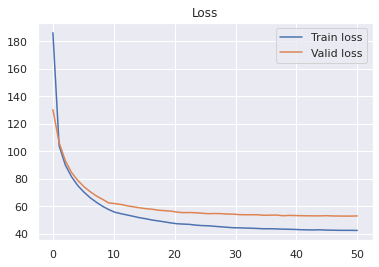

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_loss)
plt.plot(x,v_loss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

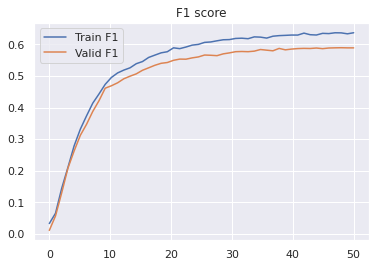

In [11]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_f1)
plt.plot(x,v_f1)
plt.title("F1 score")
plt.legend(["Train F1", "Valid F1"])

In [12]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
model.load_state_dict(torch.load('tut3-model_conll.pt'))

test_loss, test_f1, preds, labels = evaluate(model, test_iterator, TAG_PAD_IDX, full_report=False)
print(f'Test Loss: {test_loss:.3f} |  Test F1 score: {test_f1*100:.2f}%')

Test Loss: 51.947 |  Test F1 score: 52.48%


In [13]:
predict =  [item for sublist in preds for item in sublist]
true =  [item for sublist in labels for item in sublist]
confusion = confusion_matrix(true, predict)

### Matrice de confusion

In [18]:
confusion_df =pd.DataFrame(confusion)

confusion_df.columns=[i for i in TAG.vocab.itos]
s = pd.Series([i for i in TAG.vocab.itos])
confusion_df = confusion_df.set_index([s])

confusion_df['LOC'] = confusion_df['B-LOC'] + confusion_df['I-LOC']
confusion_df['PER'] = confusion_df['B-PER'] + confusion_df['I-PER']
confusion_df['ORG'] = confusion_df['B-ORG'] + confusion_df['I-ORG']
confusion_df['MISC'] = confusion_df['B-MISC'] + confusion_df['I-MISC']


confusion_df = confusion_df.drop(columns=[ i for i in TAG.vocab.itos if i != 'O'])

confusion_df.loc['LOC'] = confusion_df.loc['B-LOC'] + confusion_df.loc['I-LOC']
confusion_df.loc['PER'] = confusion_df.loc['B-PER'] + confusion_df.loc['I-PER']
confusion_df.loc['ORG'] = confusion_df.loc['B-ORG'] + confusion_df.loc['I-ORG']
confusion_df.loc['MISC'] = confusion_df.loc['B-MISC'] + confusion_df.loc['I-MISC']

confusion_df = confusion_df.drop([i for i in TAG.vocab.itos if i != 'O'  ])

confusion_df

,O,LOC,PER,ORG,MISC
O,38178,49,144,101,48
LOC,794,937,74,99,20
PER,1282,25,1346,106,12
ORG,969,149,209,1115,51
MISC,524,35,28,46,282


### Precision-Recall-F1Score

In [19]:
cm = confusion_df.to_numpy()

TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP

num_classes = 4
TN = []
for i in range(num_classes):
    temp = np.delete(cm, i, 0)    
    temp = np.delete(temp, i, 1) 
    TN.append(sum(sum(temp)))
    
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

prf_df =pd.DataFrame()
prf_df['Precision'] = precision
prf_df['Recall'] = recall
prf_df['F1-score'] = f1

s = pd.Series([i for i in confusion_df.index])
prf_df = prf_df.set_index([s])

prf_df

,Precision,Recall,F1-score
O,0.914509,0.991121,0.951275
LOC,0.784100,0.487006,0.600834
PER,0.747363,0.485745,0.588801
ORG,0.760055,0.447252,0.563131
MISC,0.682809,0.308197,0.424699


## Inférence

In [20]:
def tag_sentence(model, device, sentence, text_field, tag_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    max_word_len = max([len(token) for token in tokens])

    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]
    unk_idx = text_field.vocab.stoi[text_field.unk_token]  
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.as_tensor(numericalized_tokens)    
    token_tensor = token_tensor.unsqueeze(-1).to(device)

    predictions, _ = model(token_tensor)
    predicted_tags = [tag_field.vocab.itos[t] for t in predictions[0]]
    
    return tokens, predicted_tags, unks

In [21]:
example_index = 6

sentence = vars(valid_data.examples[example_index])['text']
actual_tags = vars(valid_data.examples[example_index])['tag']

print(sentence)
print(actual_tags)

['Trailing', 'by', '213', ',', 'Somerset', 'got', 'a', 'solid', 'start', 'to', 'their', 'second', 'innings', 'before', 'Simmons', 'stepped', 'in', 'to', 'bundle', 'them', 'out', 'for', '174', '.']
['O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [22]:
tokens, pred_tags, unks = tag_sentence(model, 
                                       device, 
                                       sentence, 
                                       TEXT, 
                                       TAG
                                      )
print(pred_tags)
print(actual_tags)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [23]:
print("Pred. Tag\t\t\t\tActual Tag\t\t\t\tCorrect?\t\t\t\tToken\n")
for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    space = 5 if pred_tag == 'O'else 4
    space1 = 5 if actual_tag == 'O'else 4   
    print(pred_tag,"\t"*space, actual_tag, "\t"*space1, correct,"\t"*5, token)

Pred. Tag				Actual Tag				Correct?				Token

O 					 O 					 ✔ 					 Trailing
O 					 O 					 ✔ 					 by
O 					 O 					 ✔ 					 213
O 					 O 					 ✔ 					 ,
O 					 B-ORG 				 ✘ 					 Somerset
O 					 O 					 ✔ 					 got
O 					 O 					 ✔ 					 a
O 					 O 					 ✔ 					 solid
O 					 O 					 ✔ 					 start
O 					 O 					 ✔ 					 to
O 					 O 					 ✔ 					 their
O 					 O 					 ✔ 					 second
O 					 O 					 ✔ 					 innings
O 					 O 					 ✔ 					 before
B-PER 				 B-PER 				 ✔ 					 Simmons
O 					 O 					 ✔ 					 stepped
O 					 O 					 ✔ 					 in
O 					 O 					 ✔ 					 to
O 					 O 					 ✔ 					 bundle
O 					 O 					 ✔ 					 them
O 					 O 					 ✔ 					 out
O 					 O 					 ✔ 					 for
O 					 O 					 ✔ 					 174
O 					 O 					 ✔ 					 .


In [24]:
sentence = 'The will deliver a speech about the conflict in North Korea tomorrow in New York with my friend Mary Kate.'
tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence, 
                                  TEXT, 
                                  TAG
                                )

print(unks)
print("Pred. Tag\tToken\n")


for token, tag in zip(tokens, tags):
    space = 2 if tag == 'O'else 1
    print(tag, "\t"*space, token)

[]
Pred. Tag	Token

O 		 The
O 		 will
O 		 deliver
O 		 a
O 		 speech
O 		 about
O 		 the
O 		 conflict
O 		 in
B-LOC 	 North
I-LOC 	 Korea
O 		 tomorrow
O 		 in
B-LOC 	 New
I-LOC 	 York
O 		 with
O 		 my
O 		 friend
B-LOC 	 Mary
I-LOC 	 Kate
O 		 .
